## Deep Learning with Keras - Google Analytics Customer Revenue Prediction
* Note: this is just a starting point, there's a lot of work to be done.
* A begginer version with [LGBM](https://www.kaggle.com/dimitreoliveira/lgbm-google-store-revenue-prediction)

### Dependencies

In [1]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

%matplotlib inline
pd.options.display.max_columns = 999

Using TensorFlow backend.


### Auxiliar functions

In [2]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    
    return df


def plot_metrics(loss, val_loss):
    fig, (ax1) = plt.subplots(1, 1, sharex='col', figsize=(20,7))
    ax1.plot(loss, label='Train loss')
    ax1.plot(val_loss, label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')
    plt.xlabel('Epochs')

Function to load and convert files borrowed from this [kernel](https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook), thanks!

In [3]:
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)

    for column in JSON_COLUMNS:
        df = df.join(pd.DataFrame(df.pop(column).apply(pd.io.json.loads).values.tolist(), index=df.index))

    return df

In [4]:
train = load_df("../input/train.csv")
test = load_df("../input/test.csv")

### About the train data

In [5]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,go

### This is how our data looks like

In [6]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 903653
Columns: 50
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserSize' 'browserVersion' 'deviceCategory' 'flashVersion' 'isMobile'
 'language' 'mobileDeviceBranding' 'mobileDeviceInfo'
 'mobileDeviceMarketingName' 'mobileDeviceModel' 'mobileInputSelector'
 'operatingSystem' 'operatingSystemVersion' 'screenColors'
 'screenResolution' 'city' 'cityId' 'continent' 'country' 'latitude'
 'longitude' 'metro' 'networkDomain' 'networkLocation' 'region'
 'subContinent' 'bounces' 'hits' 'newVisits' 'pageviews'
 'transactionRevenue' 'visits' 'adContent' 'adwordsClickInfo' 'campaign'
 'campaignCode' 'isTrueDirect' 'keyword' 'medium' 'referralPath' 'source']

TEST SET
Rows: 804684
Columns: 48
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserSize' 'browserVersion' 'deviceCategory' 'flash

### Feature engineering

In [7]:
train = add_time_features(train)
test = add_time_features(test)
# Convert target feature to 'float' type.
train["transactionRevenue"] = train["transactionRevenue"].astype('float')
train['hits'] = train['hits'].astype(float)
test['hits'] = test['hits'].astype(float)
train['pageviews'] = train['pageviews'].astype(float)
test['pageviews'] = test['pageviews'].astype(float)

### Agregated features

In [8]:
# Train
gp_fullVisitorId_train = train.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_train['fullVisitorId'] = gp_fullVisitorId_train.index
gp_fullVisitorId_train['mean_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['hits'].transform('mean')
gp_fullVisitorId_train['mean_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['pageviews'].transform('mean')
gp_fullVisitorId_train['sum_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['hits'].transform('sum')
gp_fullVisitorId_train['sum_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['pageviews'].transform('sum')
gp_fullVisitorId_train = gp_fullVisitorId_train[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
train = train.join(gp_fullVisitorId_train, on='fullVisitorId', how='inner', rsuffix='_')
train.drop(['fullVisitorId_'], axis=1, inplace=True)

# Test
gp_fullVisitorId_test = test.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_test['fullVisitorId'] = gp_fullVisitorId_test.index
gp_fullVisitorId_test['mean_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['hits'].transform('mean')
gp_fullVisitorId_test['mean_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['pageviews'].transform('mean')
gp_fullVisitorId_test['sum_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['hits'].transform('sum')
gp_fullVisitorId_test['sum_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['pageviews'].transform('sum')
gp_fullVisitorId_test = gp_fullVisitorId_test[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
test = test.join(gp_fullVisitorId_test, on='fullVisitorId', how='inner', rsuffix='_')
test.drop(['fullVisitorId_'], axis=1, inplace=True)

### Exploratory data analysis

#### Let's take a look at our target value through the time.

In [9]:
time_agg = train.groupby('date')['transactionRevenue'].agg(['count', 'sum'])
year_agg = train.groupby('year')['transactionRevenue'].agg(['sum'])
month_agg = train.groupby('month')['transactionRevenue'].agg(['sum'])
day_agg = train.groupby('day')['transactionRevenue'].agg(['sum'])
weekday_agg = train.groupby('weekday')['transactionRevenue'].agg(['count','sum'])

#### Here is sum of our tagert feature "transactionRevenue" through the time.

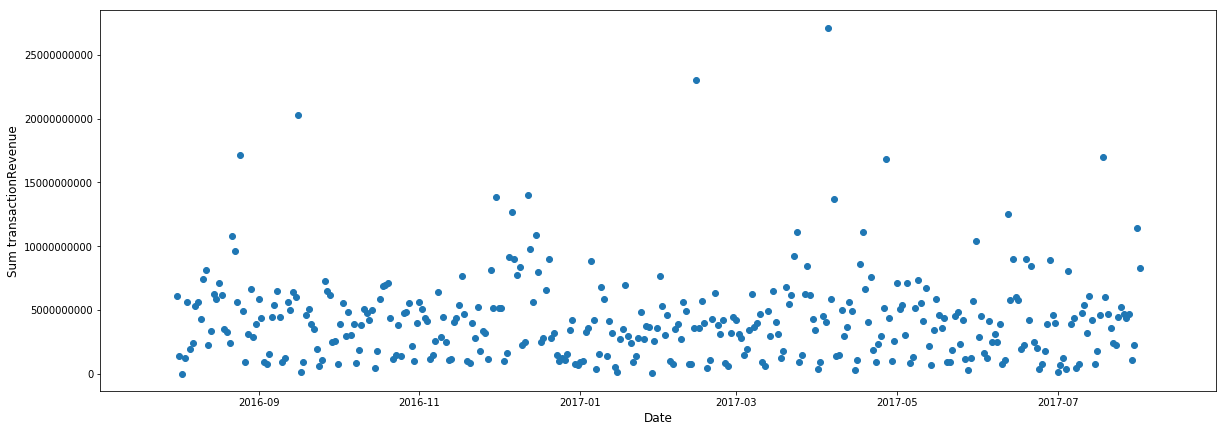

In [10]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Sum transactionRevenue', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['sum'])
plt.show()

Seems we had more transactions on late 2016 and early 2017, date features seems to be a good addition to our model.

#### And here count of our target feature "transactionRevenue".

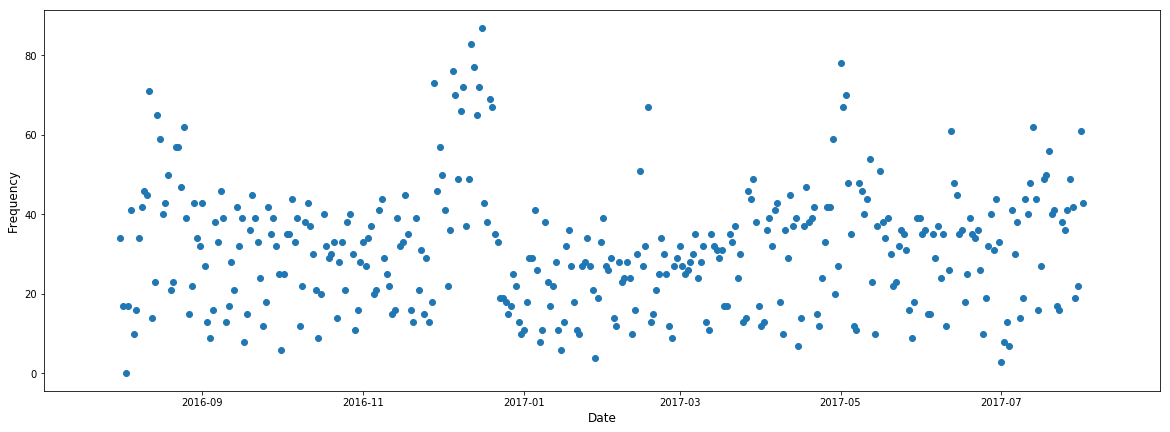

In [11]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['count'])
plt.show()

Again we had higher frequency at a similar time period.

#### Let's take a look at other time features.

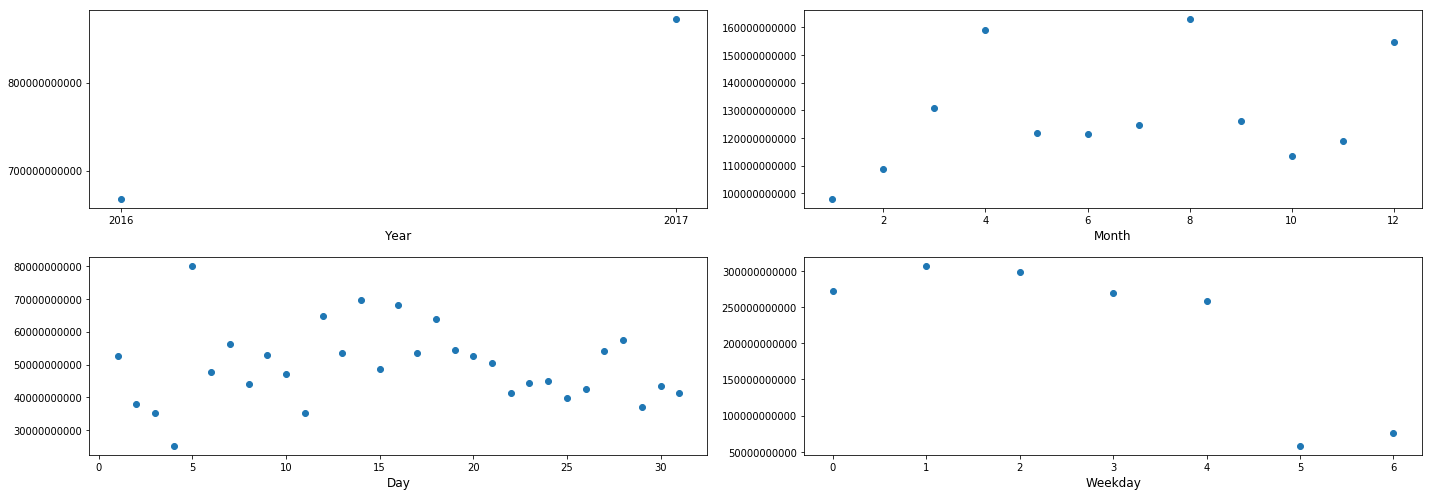

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,7))
ax1.scatter(year_agg.index.values, year_agg['sum'])
ax1.locator_params(nbins=2)
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xlabel('Year', fontsize=12)

ax2.scatter(month_agg.index.values, month_agg['sum'])
ax2.locator_params(nbins=12)
ax2.ticklabel_format(axis='y', style='plain')
ax2.set_xlabel('Month', fontsize=12)

ax3.scatter(day_agg.index.values, day_agg['sum'])
ax3.locator_params(nbins=10)
ax3.ticklabel_format(axis='y', style='plain')
ax3.set_xlabel('Day', fontsize=12)

ax4.scatter(weekday_agg.index.values, weekday_agg['sum'])
ax4.locator_params(nbins=7)
ax4.ticklabel_format(axis='y', style='plain')
ax4.set_xlabel('Weekday', fontsize=12)

plt.tight_layout()
plt.show()

### About the engineered time features
* Year: It seem transactions had a large increase from 2016 to 2017
* Month: Lager transaction on december seems ok, but about months but im not sure why high values on april and august (maybe because of easter (april) or Tax-free weekend, back-to-school season(august)?)
* Day: Here it seems that not really important is going on, seems this features can be discarded.
* Weekday: Something strange is going on here, seems that weekends have less transactions?

### The let's do some cleaning

In [13]:
# Drop stange 'dict' column
train = train.drop(['adwordsClickInfo'], axis=1)
test = test.drop(['adwordsClickInfo'], axis=1)
# Drop column that exists only in train data
train = train.drop(['campaignCode'], axis=1)
# Input missing transactionRevenue values
train["transactionRevenue"].fillna(0, inplace=True)

test_ids = test["fullVisitorId"].values

### Drop unwanted columns

In [14]:
# Unwanted columns
unwanted_columns = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime', 
                    'browser', 'browserSize', 'browserVersion', 'flashVersion', 
                    'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel', 
                    'mobileInputSelector', 'operatingSystemVersion', 'screenColors', 
                    'metro','networkDomain', 'networkLocation', 'adContent', 'campaign', 
                    'isTrueDirect', 'keyword', 'referralPath', 'source', 'operatingSystem', 'day']

train = train.drop(unwanted_columns, axis=1)
test = test.drop(unwanted_columns, axis=1)
# Constant columns
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)
train = train.drop(constant_columns, axis=1)
test = test.drop(constant_columns, axis=1)
# Columns with more than 50% null data
high_null_columns = [c for c in train.columns if train[c].count()<=len(train) * 0.5]
print('Columns more than 50% null values: ', high_null_columns)
train = train.drop(high_null_columns, axis=1)
test = test.drop(high_null_columns, axis=1)

Columns with constant values:  ['socialEngagementType', 'language', 'mobileDeviceBranding', 'screenResolution', 'cityId', 'latitude', 'longitude', 'bounces', 'newVisits', 'visits']
Columns more than 50% null values:  []


### This is our new data with some cleaning and engineering.

In [15]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 903653
Columns: 21
Features: ['channelGrouping' 'date' 'visitNumber' 'deviceCategory' 'isMobile' 'city'
 'continent' 'country' 'region' 'subContinent' 'hits' 'pageviews'
 'transactionRevenue' 'medium' 'year' 'month' 'weekday'
 'mean_hits_per_day' 'mean_pageviews_per_day' 'sum_hits_per_day'
 'sum_pageviews_per_day']

TEST SET
Rows: 804684
Columns: 20
Features: ['channelGrouping' 'date' 'visitNumber' 'deviceCategory' 'isMobile' 'city'
 'continent' 'country' 'region' 'subContinent' 'hits' 'pageviews' 'medium'
 'year' 'month' 'weekday' 'mean_hits_per_day' 'mean_pageviews_per_day'
 'sum_hits_per_day' 'sum_pageviews_per_day']


In [16]:
train.head()

,channelGrouping,date,visitNumber,deviceCategory,isMobile,city,continent,country,region,subContinent,hits,pageviews,transactionRevenue,medium,year,month,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,2016-09-02,1,desktop,False,Izmir,Asia,Turkey,Izmir,Western Asia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
1,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Oceania,Australia,not available in demo dataset,Australasia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
2,Organic Search,2016-09-02,1,desktop,False,Madrid,Europe,Spain,Community of Madrid,Southern Europe,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
3,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Asia,Indonesia,not available in demo dataset,Southeast Asia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
4,Organic Search,2016-09-02,2,mobile,True,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,Northern Europe,1.0,1.0,0.0,organic,2016,9,4,4.324027,3.666491,90290.0,76560.0


### One-hot encode categorical data

In [17]:
categorical_features = ['isMobile', 'month', 'weekday']
train = pd.get_dummies(train, columns=categorical_features)
test = pd.get_dummies(test, columns=categorical_features)

In [18]:
# align both data sets (by outer join), to make they have the same amount of features,
# this is required because of the mismatched categorical values in train and test sets
train, test = train.align(test, join='outer', axis=1)

# replace the nan values added by align for 0
train.replace(to_replace=np.nan, value=0, inplace=True)
test.replace(to_replace=np.nan, value=0, inplace=True)

### Split data in train and validation by date
* This time based split will result in approximated 85% train and 15% validation.

In [19]:
X_train = train[train['date']<=datetime.date(2017, 5, 31)]
X_val = train[train['date']>datetime.date(2017, 5, 31)]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [20]:
# Get labels
Y_train = X_train['transactionRevenue'].values
Y_val = X_val['transactionRevenue'].values
X_train = X_train.drop(['transactionRevenue'], axis=1)
X_val = X_val.drop(['transactionRevenue'], axis=1)
test = test.drop(['transactionRevenue'], axis=1)
# Log transform the labels
Y_train = np.log1p(Y_train)
Y_val = np.log1p(Y_val)

In [21]:
reduce_features = ['city', 'medium', 'channelGrouping', 'region', 
                   'subContinent', 'country', 'continent', 'deviceCategory', 
                   'year', 'date']
X_train = X_train.drop(reduce_features, axis=1)
X_val = X_val.drop(reduce_features, axis=1)
test = test.drop(reduce_features, axis=1)

In [22]:
X_train.head()

,hits,isMobile_False,isMobile_True,mean_hits_per_day,mean_pageviews_per_day,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,pageviews,sum_hits_per_day,sum_pageviews_per_day,visitNumber,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1.0,1,0,3.943076,3.371298,0,0,0,0,0,0,0,0,0,0,0,1,1.0,83747.0,71603.0,1,0,0,0,0,1,0,0
1,1.0,1,0,3.943076,3.371298,0,0,0,0,0,0,0,0,0,0,0,1,1.0,83747.0,71603.0,1,0,0,0,0,1,0,0
2,1.0,1,0,3.943076,3.371298,0,0,0,0,0,0,0,0,0,0,0,1,1.0,83747.0,71603.0,1,0,0,0,0,1,0,0
3,1.0,1,0,3.943076,3.371298,0,0,0,0,0,0,0,0,0,0,0,1,1.0,83747.0,71603.0,1,0,0,0,0,1,0,0
4,1.0,0,1,4.324027,3.666491,0,0,0,0,0,0,0,0,0,0,0,1,1.0,90290.0,76560.0,2,0,0,0,0,1,0,0


### Normalize the data

In [23]:
normalized_features = ['visitNumber', 'hits', 'pageviews', 
                       'mean_hits_per_day', 'mean_pageviews_per_day', 
                       'sum_hits_per_day', 'sum_pageviews_per_day']

# Normalize using Min-Max scaling
scaler = preprocessing.MinMaxScaler()
X_train[normalized_features] = scaler.fit_transform(X_train[normalized_features])
X_val[normalized_features] = scaler.transform(X_val[normalized_features])
test[normalized_features] = scaler.transform(test[normalized_features])

In [24]:
X_train.head()

,hits,isMobile_False,isMobile_True,mean_hits_per_day,mean_pageviews_per_day,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,pageviews,sum_hits_per_day,sum_pageviews_per_day,visitNumber,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.0,1,0,0.000076,0.000075,0,0,0,0,0,0,0,0,0,0,0,1,0.002132,0.849059,0.851890,0.000000,0,0,0,0,1,0,0
1,0.0,1,0,0.000076,0.000075,0,0,0,0,0,0,0,0,0,0,0,1,0.002132,0.849059,0.851890,0.000000,0,0,0,0,1,0,0
2,0.0,1,0,0.000076,0.000075,0,0,0,0,0,0,0,0,0,0,0,1,0.002132,0.849059,0.851890,0.000000,0,0,0,0,1,0,0
3,0.0,1,0,0.000076,0.000075,0,0,0,0,0,0,0,0,0,0,0,1,0.002132,0.849059,0.851890,0.000000,0,0,0,0,1,0,0
4,0.0,0,1,0.000153,0.000146,0,0,0,0,0,0,0,0,0,0,0,1,0.002132,0.915408,0.910879,0.002591,0,0,0,0,1,0,0


### Model
* Now let's try some deep learning to model our data.

In [25]:
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0003

In [26]:
model = Sequential()
model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

In [27]:
adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)

In [28]:
print('Dataset size: %s' % X_train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % X_train.shape[1])
print('Features used: %s' % X_train.columns.values)

Dataset size: 765707
Epochs: 100
Learning rate: 0.0003
Batch size: 64
Input dimension: 28
Features used: ['hits' 'isMobile_False' 'isMobile_True' 'mean_hits_per_day'
 'mean_pageviews_per_day' 'month_1' 'month_10' 'month_11' 'month_12'
 'month_2' 'month_3' 'month_4' 'month_5' 'month_6' 'month_7' 'month_8'
 'month_9' 'pageviews' 'sum_hits_per_day' 'sum_pageviews_per_day'
 'visitNumber' 'weekday_0' 'weekday_1' 'weekday_2' 'weekday_3' 'weekday_4'
 'weekday_5' 'weekday_6']


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               7424      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 40,449
Trainable params: 40,449
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(x=X_train.values, y=Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(X_val.values, Y_val))

Train on 765707 samples, validate on 137946 samples
Epoch 1/100
765707/765707 [==============================] - 34s 45us/step - loss: 3.2467 - val_loss: 3.6989
Epoch 2/100
765707/765707 [==============================] - 31s 40us/step - loss: 3.1060 - val_loss: 3.6718
Epoch 3/100
765707/765707 [==============================] - 31s 41us/step - loss: 3.0826 - val_loss: 3.6116
Epoch 4/100
765707/765707 [==============================] - 31s 40us/step - loss: 3.0685 - val_loss: 3.5527
Epoch 5/100
765707/765707 [==============================] - 31s 40us/step - loss: 3.0596 - val_loss: 3.5430
Epoch 6/100
765707/765707 [==============================] - 30s 40us/step - loss: 3.0474 - val_loss: 3.7632
Epoch 7/100
765707/765707 [==============================] - 30s 40us/step - loss: 3.0377 - val_loss: 3.6501
Epoch 8/100
765707/765707 [==============================] - 31s 40us/step - loss: 3.0294 - val_loss: 3.6562
Epoch 9/100
765707/765707 [==============================] - 30s 40us/step -

### Model metrics and plot

In [31]:
val_predictions = model.predict(X_val)
mse = mean_squared_error(val_predictions, Y_val)
rmse = np.sqrt(mean_squared_error(val_predictions, Y_val))

print('Model validation metrics')
print('MSE: %.2f' % mse)
print('RMSE: %.2f' % rmse)

Model validation metrics
MSE: 54.25
RMSE: 7.37


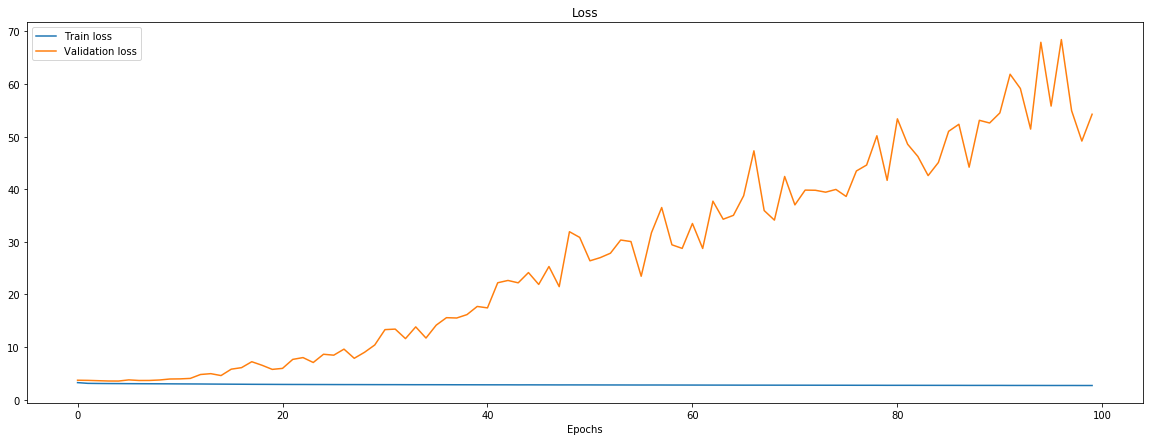

In [32]:
plot_metrics(history.history['loss'], history.history['val_loss'])

In [33]:
predictions = model.predict(test)

submission = pd.DataFrame({"fullVisitorId":test_ids})
predictions[predictions<0] = 0
submission["PredictedLogRevenue"] = predictions
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"]
submission.to_csv("submission.csv", index=False)

In [34]:
submission.head(10)

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.324378
1,0000049363351866189,0.021284
2,0000053049821714864,0.002768
3,0000059488412965267,0.036359
4,0000085840370633780,0.000000
5,0000091131414287111,0.000000
6,0000117255350596610,5.692664
7,0000118334805178127,0.000000
8,0000130646294093000,0.044154
9,0000150005271820273,0.075068
